In [1]:
import pandas as pd
from scipy.io import mmread
import scanpy as sc
import os
import sys
sys.path.append(os.path.abspath('../../'))
import SortedNoDupeBedOverlap as bdO
import annotate_sc_atac


In [2]:
mat = mmread('filtered_peak_bc_matrix/matrix.mtx')

In [10]:
mat = mat.toarray()

In [4]:
id2bc = pd.read_csv('filtered_peak_bc_matrix/barcodes.tsv', header = None)[0].values
id2peak = bdO.BedScan('filtered_peak_bc_matrix/peaks.bed')

In [5]:
#id2bc = id2bc[::10]

In [6]:
df_peak = pd.read_csv('filtered_peak_bc_matrix/peaks.bed', header = None, sep = '\t')

In [7]:
len(id2peak)

74633

In [11]:
data_obj = sc.AnnData(mat.T, 
          obs = pd.DataFrame([], index = id2bc),
          var = df_peak,
          )

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
sc.pp.normalize_total(data_obj)
sc.pp.pca(data_obj, n_comps=50)
sc.pp.neighbors(data_obj)
sc.tl.umap(data_obj)

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 0 as categorical


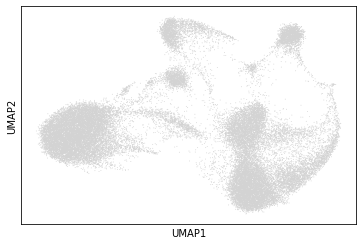

In [13]:
sc.pl.umap(data_obj)

In [14]:
ref_subtype_peaks, ref_bk_peak = annotate_sc_atac.read_reference_data('../../data/GSE97887/', verbose = False)

In [15]:
len(id2peak), len(ref_subtype_peaks[1])

(74633, 2)

In [16]:
len(ref_subtype_peaks[1][1])

4737

In [17]:
intersect = bdO.BedOverlap(id2peak, ref_bk_peak, 50)

set2_ref = []
for i, (ct, peaks) in enumerate(ref_subtype_peaks):
    peaks_intersect = bdO.BedOverlap(id2peak, sorted(peaks), 50)
    ref_subtype_peaks[i] = (ct, peaks_intersect)

In [18]:
for c, peaks in ref_subtype_peaks:
    print(c, len(peaks))

Ast 1749
End 428
Ex 5451
In 1719
Oli 3511
Opc 1722


In [19]:
mat.shape, len(id2peak)

((74633, 36286), 74633)

In [20]:
scores = annotate_sc_atac.compute_enrichment_score(mat, intersect, id2peak, ref_subtype_peaks, num_cores = 1)

In [21]:
score_df = pd.DataFrame(scores, 
                        columns = [c for c, _ in ref_subtype_peaks],
                       index = data_obj.obs.index
                       )

In [22]:
score_df.head()

,Ast,End,Ex,In,Oli,Opc
AAACGAAAGAATACTG-4,0.539136,0.900738,1.850057,1.144115,0.368345,0.420115
AAACGAAAGACTAATG-4,2.480414,2.283385,0.430096,0.000000,0.623563,2.938946
AAACGAAAGAGAGTAG-1,1.211019,5.440282,0.298476,0.122288,0.823156,1.232163
AAACGAAAGAGCTGTG-3,4.147535,0.291151,0.355513,0.720166,1.416518,2.804104
AAACGAAAGAGGAATG-5,0.639319,0.854963,1.583814,1.246130,0.628325,0.725263


In [23]:
data_obj.obs = score_df

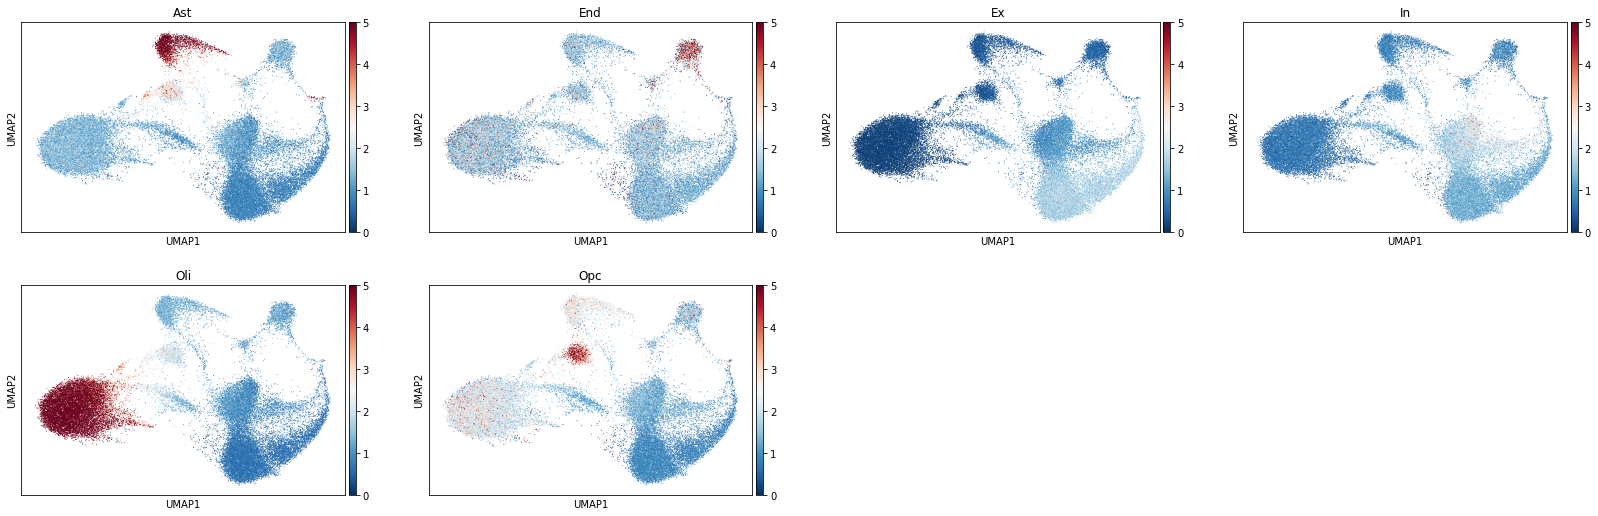

In [24]:
sc.pl.umap(data_obj, color = score_df.columns, cmap = 'RdBu_r', vmax = 5)